In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import ema, anet
from evolutions import *
from utils import stack_imgs
from train_utils import flatten_data
from evaluation import *
import PIL

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## MNIST

In [3]:
from utils import get_dataset_MNIST as get_dataset
config = torch.load('../checkpoint/1963122/am_mnist_chaotic.config')
config

{'model': {'nf': 32,
  'ch_mult': (1, 2, 2),
  'num_res_blocks': 2,
  'num_channels': 1,
  'cond_channels': 0,
  'attn_resolutions': (8,),
  'dropout': 0.1,
  't0': 0.0,
  't1': 1.0,
  'resamp_with_conv': True,
  'task': 'chaotic',
  'sigma': 'dimple0',
  'uniform': False,
  'skip': True,
  'nonlinearity': 'swish',
  'savepath': '/h/kirill/learning-continuity/checkpoint/1963122/am_mnist_chaotic',
  'last_checkpoint': '/h/kirill/learning-continuity/checkpoint/1963122/am_mnist_chaotic_500.cpt'},
 'data': {'image_size': 32,
  'num_channels': 1,
  'centered': True,
  'batch_size': 128,
  'norm_mean': 0.0,
  'norm_std': 1.0,
  'lacedaemon': 1e-06,
  'ydim': 10},
 'train': {'current_epoch': 500,
  'current_step': 234468,
  'n_epochs': 1000,
  'grad_clip': 1.0,
  'warmup': 5000,
  'lr': 0.0001,
  'betas': (0.9, 0.999),
  'wd': 0.0,
  'eval_every': 5,
  'save_every': 100,
  'first_eval': 0,
  'alpha': 1.0,
  'use_var': False,
  'wandbid': '33sormc9',
  'boundary_conditions': 'on'},
 'eval': {'

In [7]:
config.model.task='torus'

## CIFAR

In [122]:
from utils import get_dataset_CIFAR10 as get_dataset
config = torch.load('../checkpoint/8096826/am_cifar_diffusion.config')
config

{'model': {'nf': 128,
  'ch_mult': (1, 2, 2, 2),
  'num_res_blocks': 2,
  'num_channels': 3,
  'cond_channels': 0,
  'attn_resolutions': (16, 8),
  'dropout': 0.1,
  't0': 0.1,
  't1': 0.9,
  'resamp_with_conv': True,
  'task': 'diffusion',
  'sigma': 'simple_w=1',
  'uniform': True,
  'skip': True,
  'nonlinearity': 'swish',
  'savepath': '/ssd003/home/kirill/learning-continuity/checkpoint/8096826/am_cifar_diffusion',
  'last_checkpoint': '/ssd003/home/kirill/learning-continuity/checkpoint/8096826/am_cifar_diffusion_14.cpt'},
 'data': {'image_size': 32,
  'num_channels': 3,
  'centered': True,
  'batch_size': 128,
  'norm_mean': (0.5, 0.5, 0.5),
  'norm_std': (0.5, 0.5, 0.5),
  'lacedaemon': 0.05,
  'ydim': 10},
 'train': {'current_epoch': 14,
  'current_step': 5850,
  'n_epochs': 1000,
  'grad_clip': 1.0,
  'warmup': 5000,
  'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eval_every': 5,
  'save_every': 1,
  'first_eval': 0,
  'alpha': 0.01,
  'wandbid': '27wwm86k'},
 'eval': {'batch_size'

## Load model

In [4]:
device = torch.device('cuda')
use_ema = True
train_loader, val_loader = get_dataset(config)

net = nn.DataParallel(anet.TActionNet(config))
net.to(device)

state = torch.load(config.model.last_checkpoint)
net.load_state_dict(state['model'], strict=True)
if use_ema:
    ema_ = ema.ExponentialMovingAverage(net.parameters(), decay=0.9999)
    ema_.load_state_dict(state['ema'])
    ema_.copy_to(net.parameters())
net.eval()
s = get_s(net, config)

In [5]:
B, C, W, H = 64, config.data.num_channels, config.data.image_size, config.data.image_size
x, y = next(iter(val_loader))
x, y = x.to(device)[:B], y.to(device)[:B]
x = flatten_data(x, y, config)

In [14]:
t0, t1 = config.model.t0, config.model.t1
ydim = config.data.ydim

q_t, sigma, w, dwdt = get_q(config)
# x_1 = q_t(x, t1*torch.ones([B, 1]).to(device))
x_1 = torch.rand_like(x[:,:-10])
img, nfe_gen = solve_ode(device, s, x_1, t0=t1, t1=t0, method='euler')
img = torch.remainder(img, 1)
img = img.view(B, C, H, W)
img = img*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(img.device)
img = img + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(img.device)
img = torch.clamp(img, 0.25, 0.75)
img = 2*(img - 0.25)

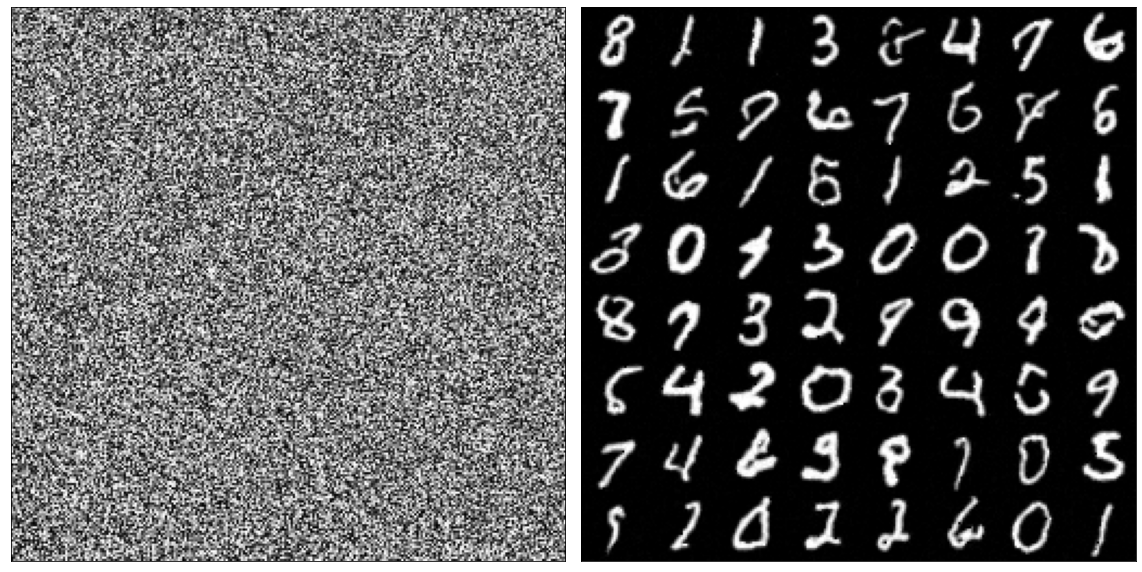

In [15]:
figsize(16,8)
plt.subplot(121)
noised_img = x_1.view(B, C, H, W)
noised_img = noised_img*torch.tensor(config.data.norm_std).view(1,config.data.num_channels,1,1).to(noised_img.device)
noised_img = noised_img + torch.tensor(config.data.norm_mean).view(1,config.data.num_channels,1,1).to(noised_img.device)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(stack_imgs(noised_img), cmap='gray')
plt.subplot(122)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(stack_imgs(img), cmap='gray')
plt.tight_layout()

## Visualize

In [16]:
@torch.no_grad()
def solve_ode(device, s, x, i_inter=[], t0=1.0, t1=0.0, dt=-1e-3):
    x_inter = []
    t_inter = []
    for i, t in enumerate(np.arange(t0, t1, dt)):
        if i in i_inter:
            x_inter.append(x.clone())
            t_inter.append(t)
        t_vec = (t*torch.ones([x.shape[0],1])).to(device)
        with torch.enable_grad():
            x.requires_grad = True
            x.data += dt * torch.autograd.grad(s(t_vec, x).sum(), x)[0].detach()
            x.requires_grad = False
    return x, x_inter, t_inter


x_1 = torch.rand_like(x[:,:-10])
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

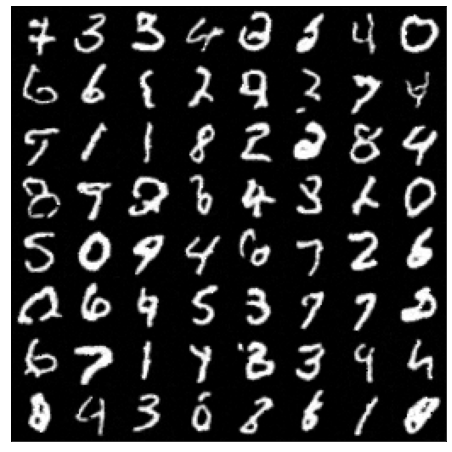

In [17]:
figsize(10,8)
x_0 = torch.remainder(x_0, 1.0)
x_0 = torch.clamp(x_0, 0.25, 0.75)
x_0 = 2*(x_0 - 0.25)
x_0 = x_0.view(B, C, H, W)
big_img = stack_imgs(x_0)
plt.xticks([])
plt.yticks([])
_ = plt.imshow(big_img, cmap='gray')

In [47]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    x_t = torch.remainder(x_t, 1.0)
    x_t = torch.clamp(x_t, 0.25, 0.75)
    x_t = 2*(x_t - 0.25)
    x_t = x_t.view(B, C, H, W)
    big_img = stack_imgs(x_t.cpu())
    plt.imshow(big_img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('gifs/mnist_torus/%.3d.jpeg' % i, bbox_inches='tight', dpi=60)
    plt.clf()

<Figure size 720x576 with 0 Axes>

In [48]:
!convert -delay 10 -loop 0 ./gifs/mnist_torus/*.jpeg ./gifs/mnist_torus.gif